In [1]:
from RCNNModel_Parking import RCNNModel
from backgroundSubtraction import BackgroundSubtractionCPU
import matplotlib.pyplot as plt
from matplotlib import path
import numpy as np
import cv2
import math, time, glob
# import output1317 as ot
# import output1700 as ot_seven
import output1317_18 as ot_new
import output1700_78 as ot_seven_new
%matplotlib inline

In [7]:
##All visualization methods
class DataAnalysis():
    
    def helper_calcCentroid(self, topCoord, btmCoord):
        w = btmCoord[0] - topCoord[0]
        h = btmCoord[1] - topCoord[1]
        return [(topCoord[0]+w/2), (topCoord[1]+h/2)]
    
    def showPixelFreeSpaceGraph(self, freePixelSpaceArray, totalTime):      
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "FreePixelSpace: ", freePixelSpaceArray
        
        plt.title("Free Space in Pixels")
        axis = [-20, (totalTime+1)*16, 150, 600]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (pixels)')
        
        plt.plot(secondInterval[1:], freePixelSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freePixelSpaceArray[1:], 'bo')
        
        plt.plot((axis[0], axis[1]), (300, 300), 'r--')
        plt.plot((axis[0], axis[1]), (475, 475), 'r--')
        plt.plot((axis[0], axis[1]), (789, 789), 'r--')
        plt.plot((axis[0], axis[1]), (1052, 1052), 'r--')
    
    ###RawX Coordinates
    def convertRawXCoordToDist(self, freeSpaceArray, multiplyFactor):
        pairNum = 0
        totalFtinRawDist = 0
        while pairNum < len(freeSpaceArray):
            dist = freeSpaceArray[pairNum+1] - freeSpaceArray[pairNum]
            if dist < 0:
                print "DIST WAS NEGATIVE. SETTING TO 0"
                dist = 0
            print "raw dist: ", dist
            rawDistFtperPx = dist*multiplyFactor
            print "rawDistFtperPx: ", rawDistFtperPx
            totalFtinRawDist += rawDistFtperPx
            pairNum += 2
        print "Total Feet for Raw Dist: ", totalFtinRawDist
        return totalFtinRawDist
    
    def showRawDistFreeSpaceGraph(self, freeRawDistSpaceArray, totalTime):
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "FreePixelSpace: ", freeRawDistSpaceArray
        
        plt.title("Free Space in Feet (Raw Coordinates)")
        axis = [-20, (totalTime+1)*16, 10, 45]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        plt.plot(secondInterval[1:], freeRawDistSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freeRawDistSpaceArray[1:], 'bo')
        
        plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (20, 20), 'r--')
        plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (40, 40), 'r--')
    
    ###Estimated Coordinates
    def pixelsToEstCoord(self, freeSpaceArray):
        extrapArray = []
        for xcoord in freeSpaceArray:
            extrapArray.append(self.extrapCoordinates(xcoord))
        print "extrapArray: ", extrapArray
        return extrapArray
        
    def extrapCoordinates(self, raw_x_coord):
        w_factor = [ -6.41328433e-04,   3.65880005e-07,   1.26635656e+00] #For the Ames St Parking
        #w_factor = [  9.89468130e-05  -2.32858803e-08   9.34503401e-01] #For the goPro Bleacher
        inputArray = np.array([raw_x_coord, raw_x_coord**2, 1])
        calculatedScaleFactor = inputArray.dot(w_factor)
        projectedCoordinate = raw_x_coord*calculatedScaleFactor
        return projectedCoordinate
    
    def showEstDistFreeSpaceGraph(self, freeEstDistSpaceArray, totalTime, time):
        totalTime = totalTime
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        print "EstimatedPixelSpace: ", freeEstDistSpaceArray
        
        plt.figure(figsize=(10, 8))
        plt.title("Aggregated Free Space in Feet at {0} at 1 Frame/30 Seconds".format(time))  ####################
        axis = [-20, (totalTime+1)*16, 0, 85]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        plt.plot(secondInterval[1:], freeEstDistSpaceArray[1:], 'k')
        plt.plot(secondInterval[1:], freeEstDistSpaceArray[1:], 'bo')
        
        plt.text((totalTime+1)*12, 15, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (17, 17), 'r--')
        plt.text((totalTime+1)*12, 32, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (34, 34), 'r--')
        plt.text((totalTime+1)*12, 49, r'3 Empty Spot')
        plt.plot((axis[0], axis[1]), (51, 51), 'r--')
        plt.text((totalTime+1)*12, 66, r'4 Empty Spot')
        plt.plot((axis[0], axis[1]), (68, 68), 'r--')
#         plt.savefig("FCRNN{0}_17ft_30fps_sp0-4.png".format(time)) ##################

    def allPixelsToEstCoord(self, freeSpaceArray):
        largeArray = []
        for xcoord in freeSpaceArray:
            extrapArray = []
            for x in range(len(xcoord)):
                extrapArray.append(analysis.extrapCoordinates(xcoord[x]))
            largeArray.append(extrapArray)
        print "largeArray: ", largeArray
        return largeArray
    
    def showFreeSpaceCoord(self, rawCoordArray, estCoordArray, totalTime):
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        
        plt.figure(figsize=(10, 8))
        plt.title("Comparison of Aggregated Free Space in Feet at 17:00 at 1 Frame/15 Seconds")
        axis = [-20, (totalTime+1)*16, 0, 85]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        red = plt.plot(secondInterval[1:], rawCoordArray[1:], 'ro', label='FCISS')
        plt.plot(secondInterval[1:], rawCoordArray[1:], 'k')
        blue = plt.plot(secondInterval[1:], estCoordArray[1:], 'bo', label="FRCNN")
        plt.plot(secondInterval[1:], estCoordArray[1:], 'k')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.)
#            ncol=2, mode="expand", borderaxespad=0.)
        
#         plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (17, 17), 'r--')
#         plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (34, 34), 'r--')
#         plt.text((totalTime+1)*12, 49, r'3 Empty Spot')
        plt.plot((axis[0], axis[1]), (51, 51), 'r--')
#         plt.text((totalTime+1)*12, 66, r'4 Empty Spot')
        plt.plot((axis[0], axis[1]), (68, 68), 'r--')
#         plt.savefig("CompareGraph1700_sp0-4.png") ##################

In [3]:
class Video():

#     def __init__(self, videoPath):
#         self.videoPath = videoPath
        
    def turnImg(self, image):
        rows, cols, color = image.shape
        M = cv2.getRotationMatrix2D((cols/2, rows/2), 2, 1) #For Ames St Parking
#         M = cv2.getRotationMatrix2D((cols/2, rows/2), -2, 1) #For goPro Parking
        dst = cv2.warpAffine(image, M, (cols, rows))
        return dst
        
    def detectCars(self, netmodel):
        frame_detections = []            
        dets = netmodel.carDetectionMethod(rotate)
        for det in dets:
            bbox = det[:4]
            if (bbox[2]-bbox[0])<700:
                if bbox[3] < 591:
                    frame_detections.append(bbox)
#                     cv2.rectangle(rotate,(bbox[0], bbox[1]),(bbox[2], bbox[3]), (0, 255, 0), 3 )
                else:
                    cv2.rectangle(rotate,(bbox[0], bbox[1]),(bbox[2], bbox[3]), (255, 0, 0), 3 )
        
        cv2.line(rotate, (0,590), (1599,590), (255, 0, 0), 3)
        return frame_detections
    
    #Note: If the spots are not physically marked (free space), create another method that color 
    #codes the empty space between the spaces
    def drawSpotsOccupyStatus(self, copyImg):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if spot.occupyStatus == "available":
                cv2.polylines(copyImg, [spot.staticBbox], False, (0,255, 0), 3)
            else:
                cv2.polylines(copyImg, [spot.staticBbox], False, (255, 0, 0), 3)
                
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = "ID: {0}, Occ: {1}, Stat: {2}".format(spot.ID, spot.occlusion, spot.occupyStatus)
            cv2.putText(copyImg,text, (spot.staticBbox[0][0], spot.staticBbox[0][1]), font, 0.5,(0,0,255),2)
            
    def drawAvgCenterAndBox(self, image):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if len(spot.occupiedCarSize)>0:           
                cv2.circle(image, (spot.averageCenter[0], spot.averageCenter[1]), 3, (255, 255, 0), 3)
                cv2.rectangle(image, (spot.averageBbox[0], spot.averageBbox[1]), 
                                    (spot.averageBbox[2], spot.averageBbox[3]), (255, 255, 255), 3)
                print "AverageBbox: ", spot.averageBbox

    def drawAllCenters(self, image):
#         for spot in allParking.allSpots[1:5]:
        for spot in allParking.allSpots[:5]:
            if len(spot.occupiedCarSize)>0:
                for xy in spot.allCenters:
                    cv2.circle(image, (int(xy[0]), int(xy[1])), 3, (255, 255, 255), 3)


In [4]:
class ParkingSpot():
    
    def __init__(self, spotID, topLeft, topRight, bottomRight, bottomLeft):
        self.ID = spotID
        self.occlusion = 0
        self.occupyStatus = "available"
        self.updatedTag = False
        
        self.staticBbox = np.int32([topLeft, topRight, bottomRight, bottomLeft, topLeft]) #Coordinates of the parking spot's bbox
        self.staticCentroid = analysis.helper_calcCentroid(topLeft, bottomRight)
        
        self.occupiedCarSize = []
        self.allCenters = []
        self.averageWidth = 0
        self.averageHeight = 0
        self.averageCenter = (0,0)
        self.averageBbox = []
        
    def calcAverageWidth(self):
        return sum([x[2]-x[0] for x in self.occupiedCarSize])/len(self.occupiedCarSize)
        
    def calcAverageHeight(self):
        return sum([y[3]-y[1] for y in self.occupiedCarSize])/len(self.occupiedCarSize)
    
    def calcAverageBboxCenter(self):
        allCenters = [analysis.helper_calcCentroid((coord[0], coord[1]), (coord[2], coord[3])) for coord in self.occupiedCarSize]

        xcenter = sum([coord[0] for coord in allCenters])/len(self.occupiedCarSize)
        ycenter = sum([coord[1] for coord in allCenters])/len(self.occupiedCarSize)
        centerPt = (int(xcenter), int(ycenter))
        return centerPt
        
    def calcAllCenters(self):
        return [analysis.helper_calcCentroid((coord[0], coord[1]), (coord[2], coord[3])) for coord in self.occupiedCarSize]
    
    def calcAverageBbox(self):
        TopLeft_X = int(self.averageCenter[0]-self.averageWidth/2)
        TopLeft_Y = int(self.averageCenter[1]-self.averageHeight/2)
        BtmRight_X = int(self.averageCenter[0]+self.averageWidth/2)
        BtmRight_Y = int(self.averageCenter[1]+self.averageHeight/2)
        return [TopLeft_X, TopLeft_Y, BtmRight_X, BtmRight_Y]
    
    def updateAverages(self):
        if len(self.occupiedCarSize)>0:
            self.averageWidth = self.calcAverageWidth()
            self.averageHeight = self.calcAverageHeight()
            self.averageCenter = self.calcAverageBboxCenter()
            self.allCenters = self.calcAllCenters()
            self.averageBbox = self.calcAverageBbox()


In [5]:
#Note: If the parking spaces are not physically marked, create a sort method to order the cars relative to each other
class ParkingTotalRegion():
    
    def __init__ (self):
        self.allSpots = [ParkingSpot(0, (51, 479), (322, 490), (283, 534), (8, 525)),
                         ParkingSpot(1, (337, 491), (659, 492), (656, 541), (303, 533)), 
                         ParkingSpot(2, (677, 492), (958, 494), (989, 545), (670, 542)), 
                         ParkingSpot(3, (969, 500), (1242, 499), (1300, 539), (1000, 541)), 
                         ParkingSpot(4, (1256, 501), (1435, 493), (1493, 536), (1306, 541)), 
                         ParkingSpot(5, (1450, 495), (1596, 490), (1598, 528), (1505, 535))]
        self.coordOfFreeSpaces = []
    
    def resetUpdateTags(self):
        for spot in self.allSpots:
            spot.updatedTag = False
            
    def updateAllAverages(self):
        for spot in self.allSpots:
            spot.updateAverages()

    def matchParkingSpots(self, carArray):
        for car in carArray:
            detected_centroid = analysis.helper_calcCentroid((car[0], car[1]), (car[2], car[3]))
            matchID = self.calculateNearestParkingSpot(detected_centroid)
            self.allSpots[matchID].updatedTag = True
            self.allSpots[matchID].occlusion = 0
            self.allSpots[matchID].occupiedCarSize.append(car)

            if self.allSpots[matchID].occupyStatus == "available":
                self.allSpots[matchID].occupyStatus = "taken"
            
    def calculateNearestParkingSpot(self, centroid):
        closestSpotID = 10
        shortestDist = 10000
        for spot in self.allSpots:
            dist = self.helper_distance(centroid, spot.staticCentroid)
            closestSpotID = self.helper_pickShortestDistID(dist, shortestDist, spot.ID, closestSpotID)
            shortestDist = min(dist, shortestDist)
        print "THIS IS THE SPOT THE CAR OCCUPIES: ", closestSpotID
        return closestSpotID
    
    def updateAllSpots(self):
        for spot in self.allSpots:
            if (spot.updatedTag == False) & (spot.occupyStatus == "taken"):
                if spot.occlusion > 1:
#                 if spot.occlusion > 7:
#                 if spot.occlusion > 2:
                    spot.occlusion = 0
                    spot.occupiedCarSize = []
                    spot.occupyStatus = "available"
                else:
                    spot.occlusion += 1
    
    #Adapt this method if the parking spaces are not physically defined
    def calculateFreeSpace(self):
#         leftMostX = self.allSpots[1].staticBbox[3][0]
        leftMostX = self.allSpots[0].staticBbox[3][0]
        addedFreeSpacesInPixels = 0
        freeSpaceBboxXCoord = []
        print "Len allSpots: ", len(self.allSpots)
        
        print "CALCULATING FREE SPACE"
#         for counter in range(len(self.allSpots)-2):
        for counter in range(len(self.allSpots)-1):
#             counter += 1
            print "---COUNTER: ", counter
#             print "FarthestX: ", leftMostX
            counterInfo = self.allSpots[counter]
            dist = 0
            
            if counterInfo.occupyStatus == "taken":
                print "compareVal: ", counterInfo.averageBbox[0]
                dist = counterInfo.averageBbox[0] - leftMostX
                freeSpaceBboxXCoord.append(leftMostX)
                print "avgbbox0 > LM: ", counterInfo.averageBbox[0] > 303
#                 if (counterInfo.averageBbox[0] > 303):
#                     print "avgbbox0: ", counterInfo.averageBbox[0]
#                     print "lM: ", leftMostX
                freeSpaceBboxXCoord.append(counterInfo.averageBbox[0])
                print "Updated freeSpaceBboxXCoord with leftMost: ", leftMostX
                print "Updated freeSpaceBboxXCoord with avgbbox[0]: ", counterInfo.averageBbox[0]
                
                leftMostX = counterInfo.averageBbox[2]                
                print "LEFTMOST UPDATED: ", leftMostX
                
            if counter == len(self.allSpots)-2:
                print "counterInfo stat: ", counterInfo.staticBbox[2]
                print "counterInfo avg: ", counterInfo.averageBbox
                print "Adding last bit"
                print "Dist before: ", dist
                freeSpaceBboxXCoord.append(leftMostX)
                dist += counterInfo.staticBbox[2][0] - leftMostX
                print "Updated freeSpaceBboxXCoord with sp4 LM: ", leftMostX
                freeSpaceBboxXCoord.append(counterInfo.staticBbox[2][0])
                print "Updated freeSpaceBboxXCoord with staticbbox20: ", counterInfo.staticBbox[2][0]
                    
            print "DIST: ", dist
            if dist < 0:
#                 print "Distance was negative. Setting to 0"
                dist = 0
            addedFreeSpacesInPixels += dist
#             print "addedFreeSpaces: ", addedFreeSpacesInPixels
        
        print "FreeSpace Array: ", freeSpaceBboxXCoord
        self.coordOfFreeSpaces.append(freeSpaceBboxXCoord)
        return addedFreeSpacesInPixels
    
    def helper_distance(self, pt1, pt2):
        return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
    
    def helper_pickShortestDistID(self, dist1, dist2, id1, id2):
        if dist1<dist2:
            return id1
        else:
            return id2
        

In [9]:
if __name__ == '__main__':
#     video_path = '/home/ubuntu/Parking/Pi10_RW1600_RH1200_TT900_FR15_04_26_2017_11_02_00_654759.h264'
    caffemodel = '/home/ubuntu/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel'
    prototxt = '/home/ubuntu/py-faster-rcnn/models/pascal_voc/VGG16/faster_rcnn_alt_opt/faster_rcnn_test.pt'
    
    #     frames = Video(video_path)
    netmodel = RCNNModel(prototxt, caffemodel)
    analysis = DataAnalysis()
    frames = Video()
    allParking = ParkingTotalRegion()
    
    useBackgroundSubtraction = False
    #I moved the backgroundSubtractionCPU class to another file. If it breaks, move it back.
    if useBackgroundSubtraction == True:
        noCarImage = cv2.imread('/home/ubuntu/Parking/emptySpots.jpg')
        cpuBackSub = BackgroundSubtractionCPU(noCarImage)
    
#     allimgs = sorted(glob.glob('./15secImgs2/*.jpg'))
#     allimgs = glob.glob('edgeshot.png')
    allimgs = sorted(glob.glob('/home/ubuntu/Parking/04-26_17.00.00/*.jpg'))
    
    arrayCoordinates = []
    arrayDetectedCars = []
#     arrayTotalFreeSpaceInPixels = []
#     arrayTotalFreeSpaceInRawDist = []
    arrayTotalFreeSpaceInEstDist = []
    
    for frameNum in range(len(allimgs)):
#         if frameNum%2 == 0:
#     for frameNum in range(8):
        print "FrameNum: ", frameNum
        im = cv2.imread("{0}".format(allimgs[frameNum]))
        rotate = frames.turnImg(im)

        allParking.resetUpdateTags()     
        arrayDetectedCars = frames.detectCars(netmodel)
        arrayCoordinates.append(arrayDetectedCars)
        print "allparking: ", arrayDetectedCars

        if useBackgroundSubtraction == True:
            print "use bs method"
            allCarsThisFrame = cpuBackSub.backgroundSubtractionMain(im, arrayDetectedCars)
        else:
            print "using FasterRCNN Bbox only"
            allCarsThisFrame = arrayDetectedCars

        if len(allCarsThisFrame)>0:
            allParking.matchParkingSpots(allCarsThisFrame)

        #update all parkingSpots
        allParking.updateAllSpots()
        allParking.updateAllAverages()
        calcFreeSpace = allParking.calculateFreeSpace()

        #Run through all spots + analyze average size of car
        #calc how long are each spaces occupied?
        #Size in Pixels        
#         arrayTotalFreeSpaceInPixels.append(allParking.calculateFreeSpace())
#         print "TotalFreeSpaceInPixels: ", arrayTotalFreeSpaceInPixels
        print "self.coordOfFreeSpace -1: ", allParking.coordOfFreeSpaces[-1]

        #Size Roughly in Feet
        ftperpx = 86.333/1190 #(5parkingx17ft+4linesx1/3ft)/(1493-303px)
        rawDistForThisFrame = analysis.convertRawXCoordToDist(allParking.coordOfFreeSpaces[-1], ftperpx)
#         print "RawDistForThisFrame: ", rawDistForThisFrame
#         arrayTotalFreeSpaceInRawDist.append(rawDistForThisFrame)

        #Size roughly through estimated coord
#         estftperpx = 80.0/1310 #(4parkingx20ft)/(1650-340px)
        estftperpx = 86.333/1669 #(5parkingx17ft+4linesx1/3ft)/(1679-10px)
        estArray = analysis.pixelsToEstCoord(allParking.coordOfFreeSpaces[-1])
        estDistForThisFrame = analysis.convertRawXCoordToDist(estArray, estftperpx)
        print "RawDistForThisFrame: ", rawDistForThisFrame
        print "estDistForThisFrame: ", estDistForThisFrame
        arrayTotalFreeSpaceInEstDist.append(estDistForThisFrame)

        ######Visualizations
        #Visualization and update parking spot graphic
        overlayCopy = rotate.copy()
        frames.drawSpotsOccupyStatus(overlayCopy)

        frames.drawAvgCenterAndBox(rotate)
        frames.drawAllCenters(rotate)

        cv2.addWeighted(overlayCopy, 0.4, rotate, 1 - 0.4, 0, rotate)
#         plt.imsave('analyzeImages_13.17/{0}.jpg'.format(frameNum), rotate)

        print "--------------------------------------------------"

#     print "RawDistTotalArray: ", arrayTotalFreeSpaceInRawDist
    print "EstDistTotalArray: ", arrayTotalFreeSpaceInEstDist
    print "RawPixelValues: ", allParking.coordOfFreeSpaces
    
    print "EstPixelValues: "
    analysis.allPixelsToEstCoord(allParking.coordOfFreeSpaces)
    
#     analysis.showPixelFreeSpaceGraph(arrayTotalFreeSpaceInPixels, frameNum)
#     analysis.showRawDistFreeSpaceGraph(arrayTotalFreeSpaceInRawDist, frameNum)
# analysis.showEstDistFreeSpaceGraph(arrayTotalFreeSpaceInEstDist, frameNum, "13.17")



Loaded network /home/ubuntu/py-faster-rcnn/data/faster_rcnn_models/VGG16_faster_rcnn_final.caffemodel
FrameNum:  0
allparking:  [array([  20.62778473,  410.94067383,  245.49182129,  526.40783691], dtype=float32), array([ 209.150177  ,  418.94830322,  621.46826172,  552.55401611], dtype=float32)]
using FasterRCNN Bbox only
THIS IS THE SPOT THE CAR OCCUPIES:  0
THIS IS THE SPOT THE CAR OCCUPIES:  1
Len allSpots:  6
CALCULATING FREE SPACE
---COUNTER:  0
compareVal:  20
avgbbox0 > LM:  False
Updated freeSpaceBboxXCoord with leftMost:  8
Updated freeSpaceBboxXCoord with avgbbox[0]:  20
LEFTMOST UPDATED:  245
DIST:  12
---COUNTER:  1
compareVal:  208
avgbbox0 > LM:  False
Updated freeSpaceBboxXCoord with leftMost:  245
Updated freeSpaceBboxXCoord with avgbbox[0]:  208
LEFTMOST UPDATED:  621
DIST:  -37
---COUNTER:  2
DIST:  0
---COUNTER:  3
DIST:  0
---COUNTER:  4
counterInfo stat:  [1493  536]
counterInfo avg:  []
Adding last bit
Dist before:  0
Updated freeSpaceBboxXCoord with sp4 LM:  62

In [ ]:

###FOR JIMMY'S COORDINATES
if __name__ == '__main__':
    analysis = DataAnalysis()
    frames = Video()
    allParking = ParkingTotalRegion()
    allimgs = sorted(glob.glob('./04-26_17.00.00/*.jpg'))
    noCarImage = cv2.imread('emptySpots.jpg')
    cpuBackSub = BackgroundSubtractionCPU(noCarImage)
    
    arrayCoordinates = []
    arrayDetectedCars = []
#     arrayTotalFreeSpaceInPixels = []
#     arrayTotalFreeSpaceInRawDist = []
    arrayTotalFreeSpaceInEstDist = []
    
    for frameNum in range(len(allimgs)):
#         if frameNum%2 == 0:
        print "FrameNum: ", frameNum
        im = cv2.imread("{0}".format(allimgs[frameNum]))
        rotate = frames.turnImg(im)

        allParking.resetUpdateTags()
        arrayDetectedCars = ot_seven_new.total[frameNum]
#         arrayDetectedCars = ot_new.total[frameNum]

        print "arrayDetectedCars: ", arrayDetectedCars

        ##FILTER FOR MIDLINE
        frame_detections = []            
        for det in arrayDetectedCars:
            if det[:4][3] < 591:
                frame_detections.append(det[:4]) 
        arrayDetectedCars = frame_detections
        print "frame_detections: ", frame_detections
        
        ###FILTER FOR OVERLAPPING CARS
        lastSort = []
        npFrame = np.array(frame_detections)
        sortFrame = npFrame[npFrame[:, 0].argsort()]
        print "sortFrame: ", sortFrame
        x = 0
        dontAdd = False
        while x < len(frame_detections)-1:
            print "----------x: ", x
            print "len: ", len(frame_detections)-1
            over = cpuBackSub.bb_intersection_over_union(sortFrame[x], sortFrame[x+1])
            print "over: ", over
            if over == 0:
                print "nothing to do. check: ", dontAdd
                if dontAdd == False:
                    lastSort.append(sortFrame[x])
                    dontAdd = False
                print "X: ", x
                print "len(frame_detections)", len(frame_detections)
                print x == len(frame_detections)-2
                if x == len(frame_detections)-2:
                    print "also adding this: ", x
                    lastSort.append(sortFrame[x+1])
            else:
#                 dontAdd = False
                print "adding over: ", over
                lastSort.append(over)
#                 x+=1
                dontAdd = True
            x+=1
#             print "TF: ", x < len()
        print "sort done"
        print "lastSort: ", lastSort
    
#         arrayDetectedCars = frames.detectCars(netmodel)
        arrayCoordinates.append(lastSort)
        arrayDetectedCars = lastSort
#         print "allparking: ", arrayDetectedCars

        allCarsThisFrame = arrayDetectedCars

        if len(allCarsThisFrame)>0:
            allParking.matchParkingSpots(allCarsThisFrame)

        #update all parkingSpots
        allParking.updateAllSpots()
        allParking.updateAllAverages()
        calcFreeSpace = allParking.calculateFreeSpace()

        #Run through all spots + analyze average size of car
        #calc how long are each spaces occupied?
        #Size in Pixels        
#         arrayTotalFreeSpaceInPixels.append(allParking.calculateFreeSpace())
#         print "TotalFreeSpaceInPixels: ", arrayTotalFreeSpaceInPixels
        print "self.coordOfFreeSpace -1: ", allParking.coordOfFreeSpaces[-1]

        #Size Roughly in Feet
        ftperpx = 86.333/1190 #(5parkingx17ft+4linesx1/3ft)/(1493-303px)
        rawDistForThisFrame = analysis.convertRawXCoordToDist(allParking.coordOfFreeSpaces[-1], ftperpx)
        print "RawDistForThisFrame: ", rawDistForThisFrame
#         arrayTotalFreeSpaceInRawDist.append(rawDistForThisFrame)

        #Size roughly through estimated coord
#         estftperpx = 80.0/1310 #(4parkingx20ft)/(1650-340px)
        estftperpx = 86.333/1669 #(5parkingx17ft+4linesx1/3ft)/(1679-10px)
        estArray = analysis.pixelsToEstCoord(allParking.coordOfFreeSpaces[-1])
        estDistForThisFrame = analysis.convertRawXCoordToDist(estArray, estftperpx)
        print "estDistForThisFrame: ", estDistForThisFrame
        arrayTotalFreeSpaceInEstDist.append(estDistForThisFrame)

        ######Visualizations
        #Visualization and update parking spot graphic
        overlayCopy = rotate.copy()
        frames.drawSpotsOccupyStatus(overlayCopy)

        frames.drawAvgCenterAndBox(rotate)
        frames.drawAllCenters(rotate)

        cv2.addWeighted(overlayCopy, 0.4, rotate, 1 - 0.4, 0, rotate)
#         plt.imsave('analyzeImages_13.17/{0}.jpg'.format(frameNum), rotate)

        print "--------------------------------------------------"

#     print "RawDistTotalArray: ", arrayTotalFreeSpaceInRawDist
    print "EstDistTotalArray: ", arrayTotalFreeSpaceInEstDist
    print "RawPixelValues: ", allParking.coordOfFreeSpaces
    
    print "EstPixelValues: "
    analysis.allPixelsToEstCoord(allParking.coordOfFreeSpaces)
    
#     jimmyFreeSpace = arrayTotalFreeSpaceInEstDist
    
#     analysis.showPixelFreeSpaceGraph(arrayTotalFreeSpaceInPixels, frameNum)
#     analysis.showRawDistFreeSpaceGraph(arrayTotalFreeSpaceInRawDist, frameNum)
# analysis.showEstDistFreeSpaceGraph(arrayTotalFreeSpaceInEstDist, frameNum, "13.17")


SecondInterval:  [  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435 450 465 480 495 510 525
 540 555 570 585 600 615 630 645 660 675 690 705 720 735 750 765 780 795
 810 825 840 855 870 885]


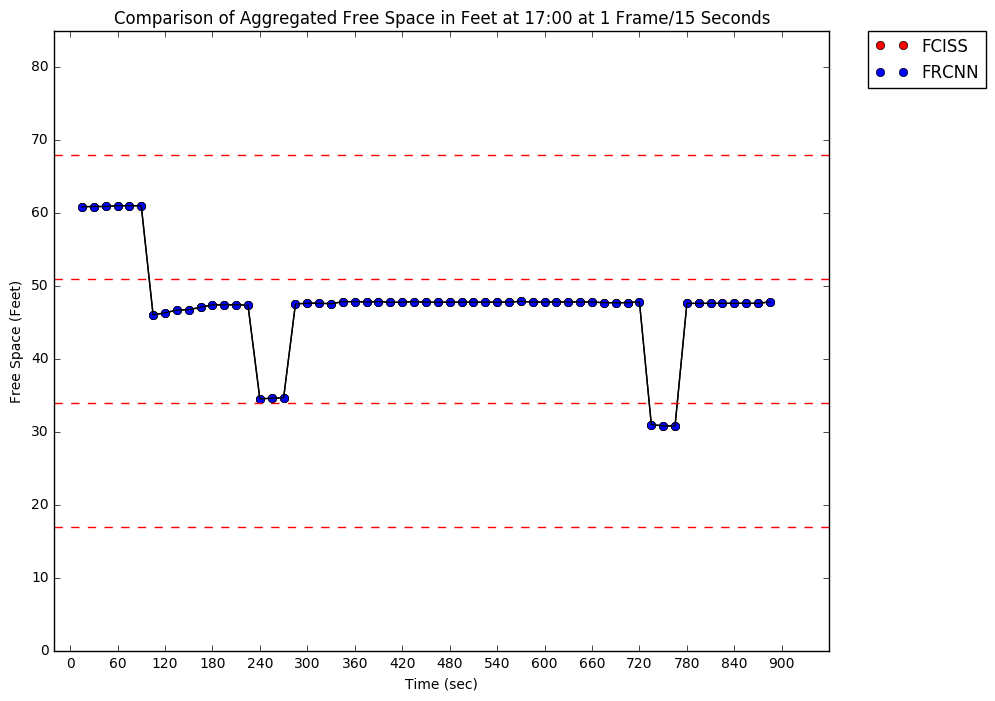

In [23]:
analysis =  DataAnalysis()
# analysis.showEstDistFreeSpaceGraph(jimmyFreeSpace, frameNum, "17.0")
analysis.showFreeSpaceCoord(jimmyFreeSpace, arrayTotalFreeSpaceInEstDist, frameNum)

SecondInterval:  [  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435 450 465 480 495 510 525
 540 555 570 585 600 615 630 645 660 675 690 705 720 735 750 765 780 795
 810 825 840 855 870 885]


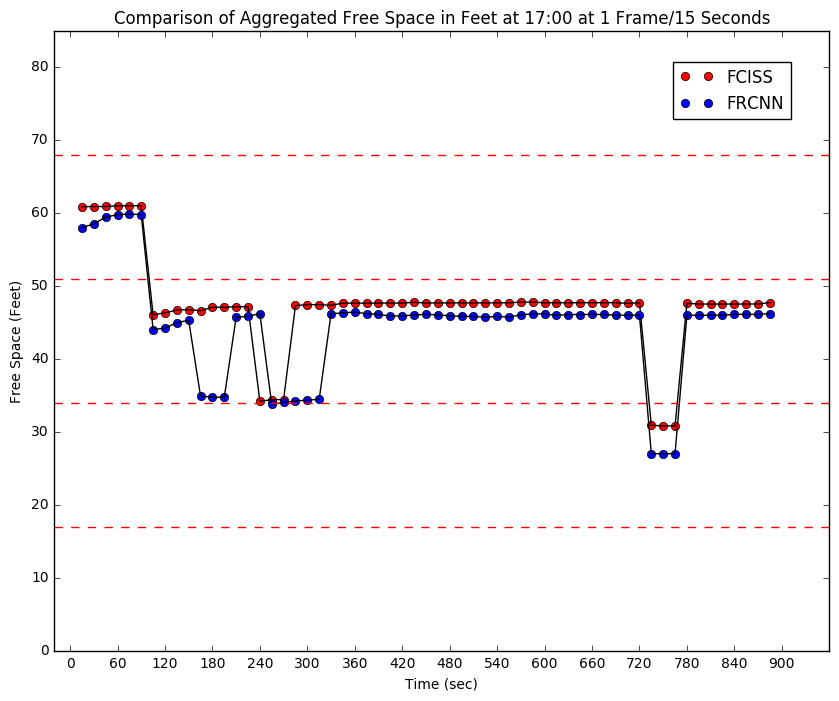

In [50]:
#THIS IS FOR 17
analysis =  DataAnalysis()
frcnn_thing =[55.194779919348278, 57.978217210912632, 58.491011483027677, 59.420617431816225, 59.751619721255317, 59.838964671450952, 59.755104897943284, 44.006641730298284, 44.192389261076727, 44.94804781918053, 45.273384807248881, 34.873242130921362, 34.740253143934652, 34.707606262091566, 45.675986870414839, 45.828688784426916, 46.167494406971549, 33.760020498164124, 34.011702739472724, 34.206033981816709, 34.326230232593296, 34.43199869643054, 46.163872884646622, 46.284371229398531, 46.395492956808027, 46.172768885332246, 46.070639106422803, 45.858089982101134, 45.866259942305476, 45.991774594184243, 46.094140827382091, 46.008453383428431, 45.893010833644993, 45.799022575813552, 45.799022575813552, 45.683868941473563, 45.807485882209548, 45.703491479979519, 46.02284542957392, 46.14836008145268, 46.14836008145268, 45.939203039175553, 46.054568420923495, 46.062728276696788, 46.070856223209375, 46.070856223209375, 45.969015120181311, 45.969015120181311, 45.967119503152468, 26.975579219761659, 26.980902751229937, 26.970853473908292, 45.962393757299097, 45.962393757299097, 45.962393757299097, 45.970572677147779, 46.086015226931217, 46.086015226931217, 46.086015226931217, 46.192551749742634]
jimmyData = [60.963975898366563, 60.843056076468919, 60.868042586897317, 60.871962563893703, 60.972018747451827, 60.972018747451827, 60.972018747451827, 46.013114031158473, 46.288167651876847, 46.679997924464317, 46.717767413362324, 46.595439670345755, 47.057684841401503, 47.04683075272451, 47.128569661305264, 47.12375881929681, 34.166685476933786, 34.383785096411223, 34.400170283001572, 47.298513651192579, 47.408811191800893, 47.416836410096096, 47.330791645175822, 47.620989426469691, 47.618280901449282, 47.62612660091682, 47.62612660091682, 47.633942208021054, 47.633942208021054, 47.735795825628273, 47.641727722761956, 47.649483145139563, 47.649483145139563, 47.657208475153851, 47.657208475153851, 47.657208475153851, 47.664903712804829, 47.664903712804829, 47.764723445892962, 47.764723445892962, 47.670796403097413, 47.670796403097413, 47.670796403097413, 47.678489079062693, 47.678489079062693, 47.678489079062693, 47.686151435552489, 47.584643946963496, 47.678489079062693, 30.885280022203229, 30.789229223167045, 30.789229223167045, 47.590100636516304, 47.496282353758197, 47.496282353758197, 47.496282353758197, 47.496282353758197, 47.50394101300143, 47.50394101300143, 47.699694682563802]
# analysis.showEstDistFreeSpaceGraph(jimmyFreeSpace, frameNum, "17.0")
analysis.showFreeSpaceCoord(jimmyData, frcnn_thing, frameNum)

extrapArray:  [10.089994790850559, 315.30829234234892, 335.00441202055367, 658.03126843409405, 670.60972957011484, 979.06812191613528, 990.90813199999991, 1366.2568472149999, 1375.0086935314948, 1678.7555795127935, 1700.4763631234878, 1878.9705366297239]
temp:  [0.52192901155092952, 16.310072380342728, 17.328901080269898, 34.03823457023406, 34.688885430183774, 50.644630419044766, 51.257083139578185, 70.672889389222647, 71.125599483915238, 86.837630584828034, 87.961189848735813, 97.194226086790863]


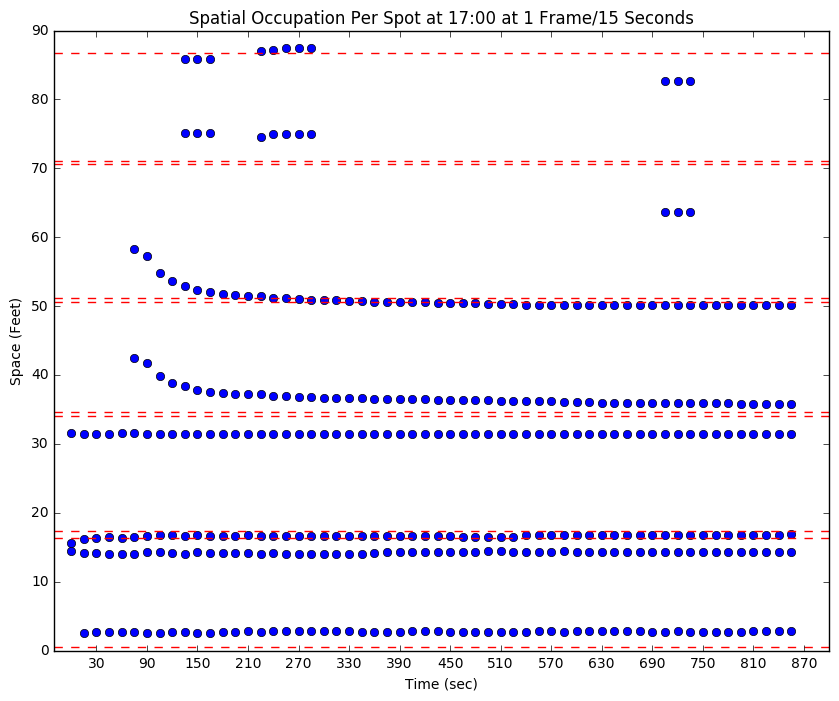

In [31]:
#17.00
EstimatedValuesPerFrame = [[10.089994790850559, 25.073526866839998, 277.14229509770564, 238.94825312224253, 626.70694908554219, 1678.7555795127935], [10.089994790850559, 58.140050571262115, 276.12393085546591, 285.26258016183436, 615.10237565382647, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 279.17679133768905, 301.36464207793256, 609.74967884094406, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 273.0643472963946, 312.33148552255994, 608.85771166725601, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 273.0643472963946, 316.29923557000353, 608.85771166725601, 1678.7555795127935], [10.089994790850559, 50.867762679951603, 272.04298184831998, 317.2895196003206, 607.96578119999992, 1678.7555795127935], [10.089994790850559, 50.867762679951603, 269.99798138791436, 316.29923557000353, 610.64168491634416, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 271.02086061058662, 317.2895196003206, 609.74967884094406, 821.34640172167053, 1127.8720245094401, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 275.10481960468752, 320.25643846004732, 608.85771166725601, 806.06209296839552, 1106.3405228054739, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 275.10481960468752, 323.21750357381785, 607.96578119999992, 770.26951237081255, 1059.7924551290396, 1678.7555795127935], [10.089994790850559, 50.867762679951603, 274.08495915009041, 323.21750357381785, 607.96578119999992, 751.6868820716744, 1037.1564407264582, 1678.7555795127935], [10.089994790850559, 50.867762679951603, 272.04298184831998, 322.23112862664499, 607.07388524389592, 741.53295538827285, 1022.659665048904, 1451.7501444776547, 1659.097308142309, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 275.10481960468752, 323.21750357381785, 606.182021603664, 731.42251762904073, 1012.7203778528399, 1451.7501444776547, 1659.097308142309, 1678.7555795127935], [10.089994790850559, 49.651553227519997, 273.0643472963946, 321.24410765381486, 607.96578119999992, 725.92501848585641, 1006.1373289708057, 1451.7501444776547, 1659.097308142309, 1678.7555795127935], [10.089994790850559, 50.867762679951603, 274.08495915009041, 321.24410765381486, 606.182021603664, 723.18064680382975, 1000.6774173456655, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 274.08495915009041, 321.24410765381486, 606.182021603664, 720.43911468476563, 997.41267650103305, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 273.0643472963946, 323.21750357381785, 606.182021603664, 719.525891414429, 994.1562678099981, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 272.04298184831998, 322.23112862664499, 607.07388524389592, 719.525891414429, 994.1562678099981, 1440.9623041593748, 1682.3556587059868, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 273.0643472963946, 321.24410765381486, 607.96578119999992, 714.05291620099911, 989.82724823670185, 1448.6594556252442, 1684.1586961351113, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 271.02086061058662, 321.24410765381486, 607.96578119999992, 713.14179391091204, 988.74727490128782, 1450.203952980022, 1689.5798260959593, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 271.02086061058662, 321.24410765381486, 607.96578119999992, 712.23096297974041, 985.51279550954928, 1450.203952980022, 1689.5798260959593, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 271.02086061058662, 322.23112862664499, 607.07388524389592, 711.32042121220434, 984.43644193287082, 1450.203952980022, 1689.5798260959593, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 271.02086061058662, 321.24410765381486, 606.182021603664, 708.59050893860865, 983.36098780767634, 1678.7555795127935], [10.089994790850559, 55.72069593863062, 269.99798138791436, 322.23112862664499, 607.07388524389592, 708.59050893860865, 983.36098780767634, 1678.7555795127935], [10.089994790850559, 55.72069593863062, 269.99798138791436, 322.23112862664499, 607.07388524389592, 708.59050893860865, 981.21276913061831, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 272.04298184831998, 322.23112862664499, 607.07388524389592, 707.68110187281411, 980.1400001881949, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 274.08495915009041, 321.24410765381486, 606.182021603664, 706.77197299425495, 979.06812191613528, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 277.14229509770564, 321.24410765381486, 606.182021603664, 705.86312010765107, 977.99713211915923, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 275.10481960468752, 320.25643846004732, 607.07388524389592, 705.86312010765107, 977.99713211915923, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 320.25643846004732, 607.07388524389592, 705.86312010765107, 977.99713211915923, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 320.25643846004732, 607.07388524389592, 706.77197299425495, 976.92702860198699, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 320.25643846004732, 607.07388524389592, 704.04623352918918, 975.85780916933822, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 320.25643846004732, 607.07388524389592, 704.04623352918918, 975.85780916933822, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 318.27914662858029, 607.07388524389592, 703.13819544677096, 974.78947162593317, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 318.27914662858029, 607.07388524389592, 703.13819544677096, 974.78947162593317, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 279.17679133768905, 319.26811885006254, 606.182021603664, 702.23042457518818, 973.72201377649139, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 278.15991452668663, 319.26811885006254, 606.182021603664, 701.32291871916027, 972.65543342573346, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 277.14229509770564, 319.26811885006254, 606.182021603664, 699.50869327265002, 972.65543342573346, 1678.7555795127935], [10.089994790850559, 52.082779481998436, 277.14229509770564, 324.20323469061339, 607.07388524389592, 699.50869327265002, 970.5248964391476, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 699.50869327265002, 970.5248964391476, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 699.50869327265002, 970.5248964391476, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 278.15991452668663, 324.20323469061339, 607.07388524389592, 697.69550154499996, 970.5248964391476, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 697.69550154499996, 970.5248964391476, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 696.78928783754748, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 695.88332597396993, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 695.88332597396993, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 694.97761375898733, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 324.20323469061339, 607.07388524389592, 694.97761375898733, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 324.20323469061339, 607.07388524389592, 694.07214899731957, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 324.20323469061339, 607.07388524389592, 694.07214899731957, 968.39784310393554, 1230.9738232901798, 1598.1205775206508, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 277.14229509770564, 325.18832417231175, 606.182021603664, 693.16692949368678, 969.46093541276002, 1230.9738232901798, 1598.1205775206508, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 325.18832417231175, 606.182021603664, 693.16692949368678, 969.46093541276002, 1230.9738232901798, 1598.1205775206508, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 325.18832417231175, 606.182021603664, 693.16692949368678, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 325.18832417231175, 606.182021603664, 693.16692949368678, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 325.18832417231175, 606.182021603664, 693.16692949368678, 969.46093541276002, 1678.7555795127935], [10.089994790850559, 53.296605828940535, 276.12393085546591, 325.18832417231175, 606.182021603664, 692.26195305280896, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 325.18832417231175, 606.182021603664, 692.26195305280896, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 325.18832417231175, 606.182021603664, 692.26195305280896, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 325.18832417231175, 606.182021603664, 692.26195305280896, 968.39784310393554, 1678.7555795127935], [10.089994790850559, 54.509243916057912, 275.10481960468752, 328.13976475962369, 607.07388524389592, 692.26195305280896, 968.39784310393554, 1678.7555795127935]]
#13.17
# EstimatedValuesPerFrame = [[10.089994790850559, 336.96014949703812, 636.53665113142779, 722.26649018418584, 935.86088799398487, 1028.2155588425085, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 339.88916297653856, 633.85468911505791, 694.07214899731957, 972.65543342573346, 1041.6509272176786, 1433.3071769728681, 1678.7555795127935], [10.089994790850559, 332.06616916499996, 624.92086410409024, 676.01143822885092, 983.36098780767634, 1037.1564407264582, 1436.3642024961873, 1678.7555795127935], [10.089994790850559, 331.08550966114149, 620.4569471088297, 664.31626506415409, 997.41267650103305, 1033.7961342032386, 1437.8952257382091, 1678.7555795127935], [10.089994790850559, 330.10422388914594, 619.56436822611499, 656.23700506192324, 1000.6774173456655, 1032.6780314340424, 1439.4279255608446, 1678.7555795127935], [10.089994790850559, 320.25643846004732, 626.70694908554219, 656.23700506192324, 1007.2321325859667, 1030.4448118317853, 1439.4279255608446, 1678.7555795127935], [10.089994790850559, 314.31668772207678, 626.70694908554219, 651.7539866988842, 1008.3278817534923, 1031.5609247086511, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 316.29923557000353, 624.92086410409024, 649.96178927974313, 986.59005073299159, 1031.5609247086511, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 317.2895196003206, 624.02793704321311, 646.37902915098141, 990.90813199999991, 1029.3296906081644, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 316.29923557000353, 626.70694908554219, 642.79833155331255, 993.07263959136799, 1030.4448118317853, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 318.27914662858029, 626.70694908554219, 641.00871229803738, 995.24081523763232, 1029.3296906081644, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 320.25643846004732, 624.92086410409024, 641.90346295977827, 998.49999472735965, 1032.6780314340424, 1439.4279255608446, 1678.7555795127935], [10.089994790850559, 318.27914662858029, 626.70694908554219, 640.11407737280911, 1000.6774173456655, 1033.7961342032386, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 319.26811885006254, 625.81386738644005, 638.32514595077237, 1000.6774173456655, 1033.7961342032386, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 318.27914662858029, 626.70694908554219, 637.43084506340369, 1001.7675261282048, 1032.6780314340424, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 318.27914662858029, 628.49335651512479, 636.53665113142779, 1002.8585694867087, 1032.6780314340424, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 319.26811885006254, 629.38668663616511, 635.64256195956489, 1003.9505496164567, 1033.7961342032386, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 321.24410765381486, 629.38668663616511, 635.64256195956489, 1006.1373289708057, 1033.7961342032386, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 319.26811885006254, 629.38668663616511, 635.64256195956489, 1008.3278817534923, 1032.6780314340424, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 320.25643846004732, 630.28010395507818, 634.74857535253489, 1009.4245786686625, 1032.6780314340424, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 320.25643846004732, 628.49335651512479, 634.74857535253489, 1011.6208245230563, 1033.7961342032386, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 321.24410765381486, 629.38668663616511, 632.96090105185363, 1013.8208877113882, 1033.7961342032386, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 323.21750357381785, 629.38668663616511, 632.96090105185363, 1013.8208877113882, 1034.91523521152, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 323.21750357381785, 629.38668663616511, 632.06720896764239, 1014.9223562939812, 1034.91523521152, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 628.49335651512479, 632.06720896764239, 1014.9223562939812, 1034.91523521152, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 629.38668663616511, 632.06720896764239, 1014.9223562939812, 1036.0353366541665, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 632.06720896764239, 1017.128178412421, 1036.0353366541665, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 631.17361066714386, 1016.0247857958988, 1036.0353366541665, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 631.17361066714386, 1016.0247857958988, 1034.91523521152, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 628.49335651512479, 630.28010395507818, 1014.9223562939812, 1034.91523521152, 1442.4983637290798, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 630.28010395507818, 1014.9223562939812, 1036.0353366541665, 1440.9623041593748, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 631.17361066714386, 1016.0247857958988, 1036.0353366541665, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 626.70694908554219, 631.17361066714386, 1016.0247857958988, 1036.0353366541665, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 327.15658701153683, 627.60011139667722, 631.17361066714386, 1016.0247857958988, 1036.0353366541665, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 631.17361066714386, 1016.0247857958988, 1036.0353366541665, 1444.0361064652391, 1678.7555795127935], [10.089994790850559, 323.21750357381785, 627.60011139667722, 630.28010395507818, 1017.128178412421, 1036.0353366541665, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 627.60011139667722, 630.28010395507818, 1017.128178412421, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 626.70694908554219, 630.28010395507818, 1017.128178412421, 1036.0353366541665, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 626.70694908554219, 636.53665113142779, 1016.0247857958988, 1036.0353366541665, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 626.70694908554219, 635.64256195956489, 1017.128178412421, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 625.81386738644005, 635.64256195956489, 1017.128178412421, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 623.13508400852857, 635.64256195956489, 1017.128178412421, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 635.64256195956489, 1017.128178412421, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 623.13508400852857, 634.74857535253489, 1018.2325363388281, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 635.64256195956489, 1019.3378617703997, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 635.64256195956489, 1019.3378617703997, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 621.34959123661679, 634.74857535253489, 1020.4441569024164, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 621.34959123661679, 634.74857535253489, 1020.4441569024164, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 634.74857535253489, 1020.4441569024164, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 324.20323469061339, 623.13508400852857, 634.74857535253489, 1020.4441569024164, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 633.85468911505791, 1021.5514239301577, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 634.74857535253489, 1022.659665048904, 1033.7961342032386, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 634.74857535253489, 1022.659665048904, 1034.91523521152, 1448.6594556252442, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 623.13508400852857, 633.85468911505791, 1021.5514239301577, 1033.7961342032386, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 623.13508400852857, 634.74857535253489, 1022.659665048904, 1033.7961342032386, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 326.17277421419294, 623.13508400852857, 633.85468911505791, 1021.5514239301577, 1033.7961342032386, 1447.1166502180413, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 633.85468911505791, 1023.7688824539349, 1034.91523521152, 1448.6594556252442, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 624.02793704321311, 633.85468911505791, 1023.7688824539349, 1034.91523521152, 1448.6594556252442, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 624.02793704321311, 633.85468911505791, 1023.7688824539349, 1034.91523521152, 1445.5755345631328, 1678.7555795127935], [10.089994790850559, 325.18832417231175, 622.24230280475649, 633.85468911505791, 1023.7688824539349, 1034.91523521152, 1445.5755345631328, 1678.7555795127935]]
xaxis = [  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255,
 270, 285, 300, 315, 330, 345, 360, 375, 390, 405, 420, 435, 450, 465, 480, 495, 510, 525,
 540, 555, 570, 585, 600, 615, 630, 645, 660, 675, 690, 705, 720, 735, 750, 765, 780, 795,
 810, 825, 840, 855, 870, 885]

spot1Left = []
spot1Right = []
allY = []
allX = []

for est in range(len(EstimatedValuesPerFrame)-2):
# for est in range(10):
    for coord in range(len(EstimatedValuesPerFrame[est+2])):
#         print "coord: ", EstimatedValuesPerFrame[est][coord]
#         print "xaxis: ", xaxis[est]
        val = EstimatedValuesPerFrame[est+2][coord]
        if (str(val) == "10.0899947909") | (str(val) == "1678.75557951"):
#             print "val: ", val
            pass
        else:
#             print "else: ", val
            allY.append(EstimatedValuesPerFrame[est+2][coord])
            allX.append(xaxis[est])

newY = []
for y in allY:
    newY.append(y*86.333/1669)
    
allY = newY

# # convertY = analysis.pixelsToEstCoord(allY)
# estftperpx = 86.333/1640 #(5parkingx17ft+4linesx1/3ft)/(1650-10px)
# convertY = analysis.convertRawXCoordToDist(allY, estftperpx)

        
# totalTime = totalTime/2
# secondInterval = np.arange(0, (totalTime+1)*15, 15)

# print "SecondInterval: ", secondInterval
# print "EstimatedPixelSpace: ", freeEstDistSpaceArray

plt.figure(figsize=(10, 8))
plt.title("Spatial Occupation Per Spot at 17:00 at 1 Frame/15 Seconds")
# axis = [-20, (totalTime+1)*16, 0, 85]
axis = [-20, max(xaxis)+15, 0, 90]
plt.axis(axis)
# plt.xticks(np.arange(0, (totalTime+1)*16, 60))
plt.xticks(np.arange(30, max(xaxis)+15, 60))
plt.xlabel('Time (sec)')
plt.ylabel('Space (Feet)')

# plt.plot(allX[1:], allY[1:], 'k')
plt.plot(allX[1:], allY[1:], 'bo')

# plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
plt.plot((axis[0], axis[1]), (0.5, 0.5), 'r--')
plt.plot((axis[0], axis[1]), (16.3, 16.3), 'r--')
# plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
# plt.plot((axis[0], axis[1]), (40, 40), 'r--')
plt.plot((axis[0], axis[1]), (17.3, 17.3), 'r--')
plt.plot((axis[0], axis[1]), (34, 34), 'r--')
# plt.text((totalTime+1)*12, 58, r'3 Empty Spot')
# plt.plot((axis[0], axis[1]), (60, 60), 'r--')
plt.plot((axis[0], axis[1]), (34.6, 34.6), 'r--')
plt.plot((axis[0], axis[1]), (50.6, 50.6), 'r--')
# plt.text((totalTime+1)*12, 78, r'4 Empty Spot')
plt.plot((axis[0], axis[1]), (51.2, 51.2), 'r--')
plt.plot((axis[0], axis[1]), (70.6, 70.6), 'r--')

plt.plot((axis[0], axis[1]), (71.1, 71.1), 'r--')
plt.plot((axis[0], axis[1]), (86.8, 86.8), 'r--')

sbbox = [8, 283, 303, 656, 670, 989, 1000, 1300, 1306, 1493, 1505, 1598]
newbbox = analysis.pixelsToEstCoord(sbbox)
temp = []
for x in newbbox:
    temp.append(x*86.333/1669)
print "temp: ", temp
# plt.savefig("FCRNN17.00_17ft_15fps_sp0-4_occupancyGraph.png")  ###########################

#         self.allSpots = [ParkingSpot(0, (51, 479), (322, 490), (283, 534), (8, 525)),
#                          ParkingSpot(1, (337, 491), (659, 492), (656, 541), (303, 533)), 
#                          ParkingSpot(2, (677, 492), (958, 494), (989, 545), (670, 542)), 
#                          ParkingSpot(3, (969, 500), (1242, 499), (1300, 539), (1000, 541)), 
#                          ParkingSpot(4, (1256, 501), (1435, 493), (1493, 536), (1306, 541)), 
#                          ParkingSpot(5, (1450, 495), (1596, 490), (1598, 528), (1505, 535))

In [22]:
print allParking.coordOfFreeSpaces

def pixelsToEstCoord(freeSpaceArray):
    largeArray = []
    for xcoord in freeSpaceArray:
#         print "xcoord array: ", xcoord
        extrapArray = []
        for x in range(len(xcoord)):
            extrapArray.append(analysis.extrapCoordinates(xcoord[x]))
#         print "ExtrapArray: ", extrapArray
        largeArray.append(extrapArray)
    print "largeArray: ", largeArray
    return largeArray

pixelsToEstCoord(allParking.coordOfFreeSpaces)

[[8, 20, 245, 208, 621, 1493], [8, 47, 244, 253, 608, 1493], [8, 40, 247, 269, 602, 1493], [8, 40, 241, 280, 601, 1493], [8, 42, 241, 284, 601, 1493], [8, 41, 240, 285, 600, 1493], [8, 41, 238, 284, 603, 1493], [8, 42, 239, 285, 602, 833, 1120, 1493], [8, 40, 243, 288, 601, 817, 1102, 1493], [8, 40, 243, 291, 600, 779, 1062, 1493], [8, 41, 242, 291, 600, 759, 1042, 1493], [8, 41, 240, 290, 599, 748, 1029, 1357, 1482, 1493], [8, 40, 243, 291, 598, 737, 1020, 1357, 1482, 1493], [8, 40, 241, 289, 600, 731, 1014, 1357, 1482, 1493], [8, 41, 242, 289, 598, 728, 1009, 1493], [8, 43, 242, 289, 598, 725, 1006, 1493], [8, 44, 241, 291, 598, 724, 1003, 1493], [8, 43, 240, 290, 599, 724, 1003, 1350, 1495, 1493], [8, 44, 241, 289, 600, 718, 999, 1355, 1496, 1493], [8, 44, 239, 289, 600, 717, 998, 1356, 1499, 1493], [8, 44, 239, 289, 600, 716, 995, 1356, 1499, 1493], [8, 44, 239, 290, 599, 715, 994, 1356, 1499, 1493], [8, 44, 239, 289, 598, 712, 993, 1493], [8, 45, 238, 290, 599, 712, 993, 1493], [8

In [ ]:
    ###Combining graphs to show similarities/differences    
    def showFreeSpaceGraphsOnePicture(self, FSA1, FSA2, totalTime):
        f, axarr = plt.subplots(2, sharex=True)
        
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        axis = [-20, (totalTime+1)*16, 150, 600]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        axarr[0].plot(secondInterval[1:], FSA1[1:], 'k')
        axarr[0].plot(secondInterval[1:], FSA1[1:], 'ro')
        
        axis = [-20, (totalTime+1)*16, 10, 50]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        axarr[1].plot(secondInterval[1:], FSA2[1:], 'bo')
        axarr[1].plot(secondInterval[1:], FSA2[1:], 'k')   
        
    def showFreeSpaceCoord(self, rawCoordArray, estCoordArray, totalTime):
        secondInterval = np.arange(0, (totalTime+1)*15, 15)
        print "SecondInterval: ", secondInterval
        
        plt.title("Free Space in Feet (Estimated Coordinates)")
        axis = [-20, (totalTime+1)*16, 10, 50]
        plt.axis(axis)
        plt.xticks(np.arange(0, (totalTime+1)*16, 60))
        plt.xlabel('Time (sec)')
        plt.ylabel('Free Space (Feet)')
        
        plt.plot(secondInterval[1:], rawCoordArray[1:], 'ro', label='Raw Coord')
        plt.plot(secondInterval[1:], rawCoordArray[1:], 'k')
        plt.plot(secondInterval[1:], estCoordArray[1:], 'bo', label="Est Coord")
        plt.plot(secondInterval[1:], estCoordArray[1:], 'k')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        plt.text((totalTime+1)*12, 18, r'1 Empty Spot')
        plt.plot((axis[0], axis[1]), (20, 20), 'r--')
        plt.text((totalTime+1)*12, 38, r'2 Empty Spot')
        plt.plot((axis[0], axis[1]), (40, 40), 'r--')


analysis = DataAnalysis()
analysis.showFreeSpaceGraphsOnePicture(arrayTotalFreeSpaceInPixels, arrayTotalFreeSpaceInEstDist, frameNum)